<a href="https://colab.research.google.com/github/wangbxj1234/huazi/blob/main/tcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备

In [1]:
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.3 MB/s eta 0:00:00
  Created wheel for compressai: filename=compressai-1.2.6-cp310-cp310-linux_x86_64.whl size=405682 sha256=db5633ae93d5849b81c8014591198ef2939be832ccc89f7c39dbee2823c68f97
  Stored in directory: /root/.cache/pip/wheels/b3/e1/85/87edc5d40a531877f35ba1cfc8f66e2e76d49d4845f57c0f46
Successfully built compressai


In [2]:
import math
import torch
import torch.nn as nn
from torch import Tensor

#from compressai.ops import ste_round
from compressai.models.utils import conv, deconv

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

from compressai.layers import (
    AttentionBlock,
    ResidualBlock,
    ResidualBlockUpsample,
    ResidualBlockWithStride,
    conv3x3,
    subpel_conv3x3,
)

/usr/local/lib/python3.10/dist-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [3]:
!pip install timm
from timm.models.layers import trunc_normal_, DropPath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.4 MB/s eta 0:00:00


In [9]:
def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True;
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]

class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W'):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        assert self.type in ['W', 'SW']
        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = ResidualBlock(self.conv_dim, self.conv_dim)

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res
        return x

# 新的对称法

In [10]:
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
from compressai.models import CompressionModel

# 定义完整图像压缩网络
#class symmetry_NET(nn.Module):
class symmetry_NET(CompressionModel):
    def __init__(self, config, N, M,drop_path_rate=0):
        super(symmetry_NET, self).__init__()
        self.head_dim = [8, 16, 32, 32, 16, 8]
        self.window_size = 8
        dim = N
        self.M = M
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]
        begin = 0

        self.m_down1 = [ConvTransBlock(dim, dim, self.head_dim[0], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[0])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down2 = [ConvTransBlock(dim, dim, self.head_dim[1], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[1])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down3 = [ConvTransBlock(dim, dim, self.head_dim[2], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[2])] + \
                      [conv3x3(2*N, M, stride=2)]

        self.m_up1 = [ConvTransBlock(dim, dim, self.head_dim[3], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[3])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up2 = [ConvTransBlock(dim, dim, self.head_dim[4], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[4])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up3 = [ConvTransBlock(dim, dim, self.head_dim[5], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[5])] + \
                      [subpel_conv3x3(2*N, 3, 2)]

        self.g_a = nn.Sequential(*[ResidualBlockWithStride(3, 2*N, 2)] + self.m_down1 + self.m_down2 + self.m_down3)


        self.g_s = nn.Sequential(*[ResidualBlockUpsample(M, 2*N, 2)] + self.m_up1 + self.m_up2 + self.m_up3)


    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return x_hat


# Hyperparameters
N = 128  # Number of channels for the network
M = 320  # Output channels
num_epochs = 10  # Number of training epochs
learning_rate = 0.0001
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
])
#cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)

kodak= '/content/drive/MyDrive/huawei/kodak'
loader = DataLoader(kodak, batch_size=2, shuffle=True)

model = symmetry_NET(config=[2,2,2,2,2,2], N=N, M=M)
model.train()  # Set to training mode

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, _ in loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, images)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
# Evaluate the model
model.eval()  # Set to evaluation mode
data_iter = iter(loader)
image, _ = next(data_iter)

# Forward pass for reconstruction
with torch.no_grad():
    reconstructed_image = model(image)

# Visualize original and reconstructed images
plt.subplot(1, 2, 1)
# 修改此行
plt.imshow(image[0].permute(1, 2, 0).numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0].squeeze().permute(1, 2, 0).numpy())
plt.title('Reconstructed Image')

plt.show()

# 选一部分插值然后直通decoder

In [ ]:


# 定义完整图像压缩网络
class ImageCompressionNetwork1(nn.Module):
    def __init__(self, N, M):
        super(ImageCompressionNetwork1, self).__init__()
        act=nn.ReLU
        self.attention=AttentionBlock(M)
        self.g_a = nn.Sequential(
            conv(3, N),  # Module 1
            ResidualBottleneckBlock(N),  # Module 2
            ResidualBottleneckBlock(N),  # Module 3
            ResidualBottleneckBlock(N),  # Module 4
            conv(N, N),  # Module 5
            ResidualBottleneckBlock(N),  # Module 6
            ResidualBottleneckBlock(N),  # Module 7
            ResidualBottleneckBlock(N),  # Module 8
            AttentionBlock(N),  # Module 9
            conv(N, N),  # Module 10
            ResidualBottleneckBlock(N),  # Module 11
            ResidualBottleneckBlock(N),  # Module 12
            ResidualBottleneckBlock(N),  # Module 13
            conv(N, M),  # Module 14
            AttentionBlock(M),  # Module 15
        )
        self.g_s = nn.Sequential(
            AttentionBlock(M),
            deconv(M, N),
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            AttentionBlock(N),
            # extractor 들어갈 구간
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, 13)
        )
        self.g_f= nn.Sequential(
            AttentionBlock(16),
            nn.Conv2d(16, 3, kernel_size=1)
        )


    def forward(self, x):
    # 计算左上1/4区域的尺寸
        h, w = x.size(2), x.size(3)
        quarter_h, quarter_w = h // 4, w // 4

    # 提取左上1/4区域
        left_top_quarter = x[:, :, :quarter_h, :quarter_w]

    # 转换左上1/4区域为灰度图像
        gray_quarter = left_top_quarter.mean(dim=1, keepdim=True)  # 生成单通道

    # 复制到3通道，形成灰度图像
        gray_quarter = gray_quarter.repeat(1, 3, 1, 1)  # 变为3通道

    # 创建一个与x相同大小的零矩阵
        black_white_image = torch.zeros_like(x)

    # 将灰度区域放回到相应的位置
        black_white_image[:, :, :quarter_h, :quarter_w] = gray_quarter

    # 融合 x_hat 和黑白图像
        y = self.g_a(x)
        x_hat = self.g_s(y)
        fused_output = torch.cat((x_hat,black_white_image),dim=1)  # 或者根据需要选择融合方式

    # 继续经过 g_a 进行特征提取
        final_output = self.g_f(fused_output)
        return final_output



# Assuming your ImageCompressionNetwork1 is already defined as above

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=1, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=192, M=320)






# Assuming your ImageCompressionNetwork1 class is defined here

# Hyperparameters
N = 192  # Number of channels for the network
M = 320  # Output channels
num_epochs = 10  # Number of training epochs
learning_rate = 0.0001
batch_size = 64

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=N, M=M)
model.train()  # Set to training mode

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, _ in loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, images)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




100%|██████████| 170498071/170498071 [00:04<00:00, 41416359.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 0.0069
Epoch [2/10], Loss: 0.0038
Epoch [3/10], Loss: 0.0021
Epoch [4/10], Loss: 0.0024
Epoch [5/10], Loss: 0.0022
Epoch [6/10], Loss: 0.0021
Epoch [7/10], Loss: 0.0014
Epoch [8/10], Loss: 0.0011
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0011


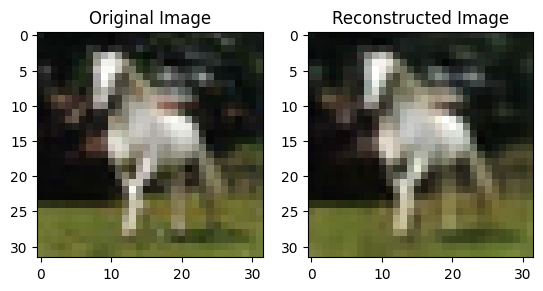

In [ ]:
# Evaluate the model
model.eval()  # Set to evaluation mode
data_iter = iter(loader)
image, _ = next(data_iter)

# Forward pass for reconstruction
with torch.no_grad():
    reconstructed_image = model(image)

# Visualize original and reconstructed images
plt.subplot(1, 2, 1)
# 修改此行
plt.imshow(image[0].permute(1, 2, 0).numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0].squeeze().permute(1, 2, 0).numpy())
plt.title('Reconstructed Image')

plt.show()